In [14]:
!pip install scipy



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [17]:
def create_test_data_vertical_sections(num_curves, num_points, plane_width, plane_height, num_samples=161, noise_type=None, noise_level=0.01, closed=False):
    """
    Generate test data consisting of multiple B-spline curves with sampled points and section bounds.

    Args:
        num_curves (int): Number of B-spline curves to generate.
        num_points (int): Number of control points per curve.
        plane_width (float): Width of the 2D plane.
        plane_height (float): Height of the 2D plane.
        num_samples (int): Number of sampled points per curve.
        noise_type (str): Type of noise to apply ('uniform' or 'gaussian').
        noise_level (float): Noise magnitude.
        closed (bool): If True, generate closed curves.

    Returns:
        List of tuples: Each tuple contains (control_points, sampled_points_clean, sampled_points_noisy, section_bounds).
    """
    data = []
    for _ in range(num_curves):
        # Generate control points and section bounds using the second approach
        control_points, section_bounds = generate_control_points_in_vertical_sections(num_points, plane_width, plane_height)

        # Sample the B-spline curve
        bspline = sample_b_spline_curve(control_points, plane_width, plane_height, closed=closed, num_samples=num_samples, noise_type=None)

        # Store control points, sampled data, and section bounds
        data.append((control_points, bspline, section_bounds))

    return data

def visualize_random_curves_from_vertical_sections(test_data, num_to_visualize, plane_width, plane_height):
    """
    Visualize a random selection of curves from the test data, including their vertical sections.

    Args:
        test_data (list): List of test data generated by create_test_data_vertical_sections.
        num_to_visualize (int): Number of curves to visualize.
        plane_width (float): Width of the 2D plane for visualization.
        plane_height (float): Height of the 2D plane for visualization.
    """
    random_indices = np.random.choice(len(test_data), num_to_visualize, replace=False)

    for idx in random_indices:
        control_points, sampled_points_clean, sampled_points_noisy, section_bounds = test_data[idx]

        # Visualize the selected curve with vertical sections and sampled points
        plot_sampling_comparison(control_points, section_bounds, plane_width, plane_height, sampled_points_clean, sampled_points_noisy)



import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import BSpline


def generate_control_points_in_vertical_sections(n, plane_width, plane_height):
    """
    Generate `n` random control points by dividing the 2D plane into vertical sections.

    Args:
        n (int): Number of control points to generate.
        plane_width (float): Width of the 2D plane.
        plane_height (float): Height of the 2D plane.

    Returns:
        List of tuples representing the (x, y) coordinates of the control points.
        Section bounds for visualization.
    """
    # Calculate the width of each vertical section
    section_width = plane_width / n

    control_points = []
    section_bounds = []

    for i in range(n):
        # Define the section bounds
        x_min = i * section_width
        x_max = (i + 1) * section_width
        y_min, y_max = 0, plane_height

        # Store section bounds for visualization
        section_bounds.append((x_min, x_max))

        # Generate a random point within this vertical section
        x = np.random.uniform(x_min, x_max)
        y = np.random.uniform(y_min, y_max)
        control_points.append((x, y))

    return control_points, section_bounds

def plot_vertical_sections_and_control_points(control_points, section_bounds, plane_width, plane_height):
    """
    Plot the 2D plane divided into vertical sections and the control points.

    Args:
        control_points (list): List of (x, y) tuples for control points.
        section_bounds (list): List of bounds for each vertical section.
        plane_width (float): Width of the 2D plane.
        plane_height (float): Height of the 2D plane.
    """
    plt.figure(figsize=(10, 6))
    # Plot the vertical sections
    for bounds in section_bounds:
        x_min, x_max = bounds
        plt.plot([x_min, x_min], [0, plane_height], 'k--', alpha=0.5)  # Left edge of the section
        plt.plot([x_max, x_max], [0, plane_height], 'k--', alpha=0.5)  # Right edge of the section

    # Plot the control points
    for i, (x, y) in enumerate(control_points):
        plt.plot(x, y, 'bo', label='Control Point' if i == 0 else None)
        plt.annotate(f'{i+1}', (x, y), textcoords="offset points", xytext=(5, 5), ha='center', color='blue')

    # Set plot limits
    plt.xlim(0, plane_width)
    plt.ylim(0, plane_height)
    plt.gca().set_aspect('auto', adjustable='box')
    plt.title('Vertical Sections and Randomly Generated Control Points')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(False)
    plt.legend()
    plt.show()


def plot_b_spline_with_vertical_sections(control_points, section_bounds, plane_width, plane_height, closed=False):
    """
    Plot the vertical sections, control polygon, and B-spline curve.

    Args:
        control_points (list): List of (x, y) tuples for control points.
        section_bounds (list): List of bounds for each vertical section.
        plane_width (float): Width of the 2D plane.
        plane_height (float): Height of the 2D plane.
        closed (bool): If True, treat the B-spline as a closed curve.
    """
    # Extract x and y coordinates from control points
    x = np.array([p[0] for p in control_points])
    y = np.array([p[1] for p in control_points])

    # Define knots for uniform cubic B-spline
    k = 3  # Cubic B-spline
    if closed:
        # Repeat the first few control points to close the curve
        x = np.concatenate((x, x[:k]))
        y = np.concatenate((y, y[:k]))
        n_knots = len(x) + k + 1
        knots = np.linspace(0, 1, n_knots)
    else:
        n_knots = len(x) + k + 1
        knots = np.concatenate((
            np.zeros(k), 
            np.linspace(0, 1, len(x) - k + 1),
            np.ones(k)
        ))

    # Create a B-spline representation
    spline_x = BSpline(knots, x, k, extrapolate=False)
    spline_y = BSpline(knots, y, k, extrapolate=False)

    # Generate points on the B-spline curve
    t_vals = np.linspace(knots[k], knots[-k-1], 1000)
    spline_curve_x = spline_x(t_vals)
    spline_curve_y = spline_y(t_vals)

    plt.figure(figsize=(10, 6))
    # Plot the vertical sections
    for bounds in section_bounds:
        x_min, x_max = bounds
        plt.plot([x_min, x_min], [0, plane_height], 'k--', alpha=0.5)  # Left edge of the section
        plt.plot([x_max, x_max], [0, plane_height], 'k--', alpha=0.5)  # Right edge of the section

    # Plot the control points
    plt.plot(x, y, 'bo-', label='Control Polygon')  # Control polygon
    for i, (cx, cy) in enumerate(control_points):
        plt.annotate(f'{i+1}', (cx, cy), textcoords="offset points", xytext=(5, 5), ha='center', color='blue')

    # Plot the B-spline curve
    plt.plot(spline_curve_x, spline_curve_y, 'r-', label='B-Spline Curve')

    # Set plot limits
    plt.xlim(0, plane_width)
    plt.ylim(0, plane_height)
    plt.gca().set_aspect('auto', adjustable='box')
    plt.title('Vertical Sections, Control Polygon, and B-Spline Curve')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(False)
    plt.legend()
    plt.show()


def sample_b_spline_curve(control_points, plane_width, plane_height, closed=False, num_samples=161, noise_type=None, noise_level=0.01):
    """
    Sample a B-spline curve at `num_samples` points and optionally perturb with noise.

    Args:
        control_points (list): List of (x, y) tuples for control points.
        plane_width (float): Width of the 2D plane.
        plane_height (float): Height of the 2D plane.
        closed (bool): If True, treat the B-spline as a closed curve.
        num_samples (int): Number of points to sample from the curve.
        noise_type (str): Type of noise to apply ('uniform' or 'gaussian').
        noise_level (float): Noise magnitude.

    Returns:
        np.ndarray: Sampled points as a (num_samples x 2) array.
    """
    # Extract x and y coordinates from control points
    x = np.array([p[0] for p in control_points])
    y = np.array([p[1] for p in control_points])

    # Define knots for uniform cubic B-spline
    k = 3  # Cubic B-spline
    if closed:
        # Repeat the first few control points to close the curve
        x = np.concatenate((x, x[:k]))
        y = np.concatenate((y, y[:k]))
        n_knots = len(x) + k + 1
        knots = np.linspace(0, 1, n_knots)
    else:
        n_knots = len(x) + k + 1
        knots = np.concatenate((
            np.zeros(k),
            np.linspace(0, 1, len(x) - k + 1),
            np.ones(k)
        ))

    # Create a B-spline representation
    spline_x = BSpline(knots, x, k, extrapolate=False)
    spline_y = BSpline(knots, y, k, extrapolate=False)

    # Generate equidistant t values within the valid range of the spline
    t_vals = np.linspace(knots[k], knots[-k-1], num_samples)

    # Sample the curve
    #todo unsampled curves
    #sampled_x = spline_x(t_vals)
    #sampled_y = spline_y(t_vals)

    # Combine x and y into a single array
    sampled_points = np.column_stack((spline_x, spline_y))

    return sampled_points

def plot_sampled_points(control_points, section_bounds, plane_width, plane_height, sampled_points, closed=False):
    """
    Plot the vertical sections, control polygon, B-spline curve, and sampled points.

    Args:
        control_points (list): List of (x, y) tuples for control points.
        section_bounds (list): List of bounds for each vertical section.
        plane_width (float): Width of the 2D plane.
        plane_height (float): Height of the 2D plane.
        sampled_points (np.ndarray): Sampled points as a (num_samples x 2) array.
        closed (bool): If True, indicate the curve is closed.
    """
    plt.figure(figsize=(10, 6))

    # Plot the vertical sections
    for bounds in section_bounds:
        x_min, x_max = bounds
        plt.plot([x_min, x_min], [0, plane_height], 'k--', alpha=0.5)  # Left edge of the section
        plt.plot([x_max, x_max], [0, plane_height], 'k--', alpha=0.5)  # Right edge of the section

    # Plot the control points and polygon
    x = np.array([p[0] for p in control_points])
    y = np.array([p[1] for p in control_points])
    plt.plot(x, y, 'bo-', label='Control Polygon')  # Control polygon
    for i, (cx, cy) in enumerate(control_points):
        plt.annotate(f'{i+1}', (cx, cy), textcoords="offset points", xytext=(5, 5), ha='center', color='blue')

    # Plot the sampled points
    plt.plot(sampled_points[:, 0], sampled_points[:, 1], 'r.', label='Sampled Points', markersize=3)

    # Set plot limits
    plt.xlim(0, plane_width)
    plt.ylim(0, plane_height)
    plt.gca().set_aspect('auto', adjustable='box')
    plt.title(f'Sampled B-Spline Curve with {len(sampled_points)} Points')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(False)
    plt.legend()
    plt.show()
    
    
    
def plot_sampling_comparison(control_points, section_bounds, plane_width, plane_height, sampled_points_clean, sampled_points_noisy):
    """
    Plot the comparison between clean and noisy sampled points.

    Args:
        control_points (list): List of (x, y) tuples for control points.
        section_bounds (list): List of bounds for each vertical section.
        plane_width (float): Width of the 2D plane.
        plane_height (float): Height of the 2D plane.
        sampled_points_clean (np.ndarray): Clean sampled points (num_samples x 2 array).
        sampled_points_noisy (np.ndarray): Noisy sampled points (num_samples x 2 array).
    """
    plt.figure(figsize=(12, 6))

    # Plot the vertical sections
    for bounds in section_bounds:
        x_min, x_max = bounds
        plt.plot([x_min, x_min], [0, plane_height], 'k--', alpha=0.5)  # Left edge of the section
        plt.plot([x_max, x_max], [0, plane_height], 'k--', alpha=0.5)  # Right edge of the section

    # Plot the control points and polygon
    x = np.array([p[0] for p in control_points])
    y = np.array([p[1] for p in control_points])
    plt.plot(x, y, 'bo-', label='Control Polygon')  # Control polygon
    for i, (cx, cy) in enumerate(control_points):
        plt.annotate(f'{i+1}', (cx, cy), textcoords="offset points", xytext=(5, 5), ha='center', color='blue')

    # Plot clean sampled points
    plt.plot(sampled_points_clean[:, 0], sampled_points_clean[:, 1], 'r.', label='Clean Sampled Points', markersize=3)

    # Plot noisy sampled points
    plt.plot(sampled_points_noisy[:, 0], sampled_points_noisy[:, 1], 'g.', label='Noisy Sampled Points', markersize=3)

    # Set plot limits
    plt.xlim(0, plane_width)
    plt.ylim(0, plane_height)
    plt.gca().set_aspect('auto', adjustable='box')
    plt.title(f'Comparison: Clean vs Noisy Sampling of B-Spline Curve')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(False)
    plt.legend()
    plt.show()



def plot_b_spline_with_vertical_sections(control_points, section_bounds, plane_width, plane_height, closed=False):
    """
    Plot the vertical sections, control polygon, and B-spline curve.

    Args:
        control_points (list): List of (x, y) tuples for control points.
        section_bounds (list): List of bounds for each vertical section.
        plane_width (float): Width of the 2D plane.
        plane_height (float): Height of the 2D plane.
        closed (bool): If True, treat the B-spline as a closed curve.
    """
    # Extract x and y coordinates from control points
    x = np.array([p[0] for p in control_points])
    y = np.array([p[1] for p in control_points])

    # Define knots for uniform cubic B-spline
    k = 3  # Cubic B-spline
    if closed:
        # Repeat the first few control points to close the curve
        x = np.concatenate((x, x[:k]))
        y = np.concatenate((y, y[:k]))
        n_knots = len(x) + k + 1
        knots = np.linspace(0, 1, n_knots)
    else:
        n_knots = len(x) + k + 1
        knots = np.concatenate((
            np.zeros(k), 
            np.linspace(0, 1, len(x) - k + 1),
            np.ones(k)
        ))

    # Create a B-spline representation
    spline_x = BSpline(knots, x, k, extrapolate=False)
    spline_y = BSpline(knots, y, k, extrapolate=False)

    # Generate points on the B-spline curve
    t_vals = np.linspace(knots[k], knots[-k-1], 1000)
    spline_curve_x = spline_x(t_vals)
    spline_curve_y = spline_y(t_vals)

    plt.figure(figsize=(10, 6))
    # Plot the vertical sections
    for bounds in section_bounds:
        x_min, x_max = bounds
        plt.plot([x_min, x_min], [0, plane_height], 'k--', alpha=0.5)  # Left edge of the section
        plt.plot([x_max, x_max], [0, plane_height], 'k--', alpha=0.5)  # Right edge of the section

    # Plot the control points
    plt.plot(x, y, 'bo-', label='Control Polygon')  # Control polygon
    for i, (cx, cy) in enumerate(control_points):
        plt.annotate(f'{i+1}', (cx, cy), textcoords="offset points", xytext=(5, 5), ha='center', color='blue')

    # Plot the B-spline curve
    plt.plot(spline_curve_x, spline_curve_y, 'r-', label='B-Spline Curve')

    # Set plot limits
    plt.xlim(0, plane_width)
    plt.ylim(0, plane_height)
    plt.gca().set_aspect('auto', adjustable='box')
    plt.title('Vertical Sections, Control Polygon, and B-Spline Curve')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(False)
    plt.legend()
    plt.show()

In [30]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import BSpline  # Assuming BSpline objects come from scipy.interpolate

def visualize_curve(control_points, curve_points, section_bounds, num_samples=161):
    """
    Visualize a curve with its control points and section bounds.
    
    Parameters:
    -----------
    control_points : array-like, shape (n, 2)
        List or array of control points.
    curve_points : numeric array, callable, or object array of BSpline objects.
        BSpline curve representation.
    section_bounds : list of tuple (x_min, x_max)
        Vertical section boundaries. If a bound is not numeric (e.g., a BSpline),
        it will be evaluated at t=0.5.
    num_samples : int, optional
        Number of sample points to evaluate if curve_points is callable.
    """
    # Ensure control_points is a numpy array.
    control_points = np.array(control_points)
    
    # Process curve_points.
    if isinstance(curve_points, np.ndarray) and curve_points.dtype == object:
        # Case: an object array with shape (1,2) containing callable BSpline objects.
        if curve_points.shape == (1, 2) and callable(curve_points[0, 0]) and callable(curve_points[0, 1]):
            t_vals = np.linspace(0, 1, num_samples)
            spline_x = curve_points[0, 0](t_vals)
            spline_y = curve_points[0, 1](t_vals)
            curve_points_eval = np.column_stack((spline_x, spline_y))
        else:
            try:
                curve_points_eval = np.array(curve_points, dtype=float)
            except Exception as e:
                raise ValueError("curve_points array could not be converted to a float array. "
                                 "It may contain non-numeric objects.") from e
    elif callable(curve_points):
        # Case: curve_points is directly callable.
        t_vals = np.linspace(0, 1, num_samples)
        curve_points_eval = curve_points(t_vals)
    else:
        # Assume curve_points is already numeric.
        curve_points_eval = np.array(curve_points, dtype=float)

    plt.figure(figsize=(10, 6))
    
    # Plot the BSpline curve.
    plt.plot(curve_points_eval[:, 0], curve_points_eval[:, 1], label='BSpline Curve', color='blue')
    
    # Plot control points.
    plt.scatter(control_points[:, 0], control_points[:, 1], color='red', label='Control Points', zorder=5)
    plt.plot(control_points[:, 0], control_points[:, 1], linestyle='--', color='red', alpha=0.5)
    
    # Process and plot section bounds.
    for idx, (x_min, x_max) in enumerate(section_bounds):
        # If x_min is not a numeric type, try to evaluate it (e.g., if it is a BSpline)
        if not isinstance(x_min, (int, float)):
            try:
                # Adjust the parameter (here 0.5) as appropriate for your BSpline.
                x_min = float(x_min(0.5))
            except Exception as e:
                raise ValueError("Section bound x_min is not numeric and could not be evaluated.") from e
        if not isinstance(x_max, (int, float)):
            try:
                x_max = float(x_max(0.5))
            except Exception as e:
                raise ValueError("Section bound x_max is not numeric and could not be evaluated.") from e
        
        plt.axvline(x=x_min, color='green', linestyle='--', 
                    label='Section Bounds' if idx == 0 else "")
        plt.axvline(x=x_max, color='green', linestyle='--')
    
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Curve Visualization with Section Bounds and Control Points')
    plt.legend()
    plt.grid(True)
    plt.show()


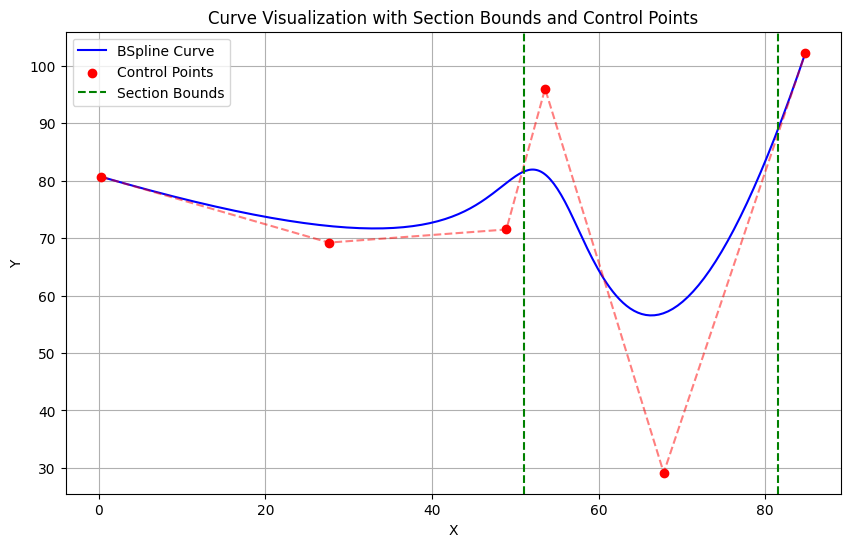

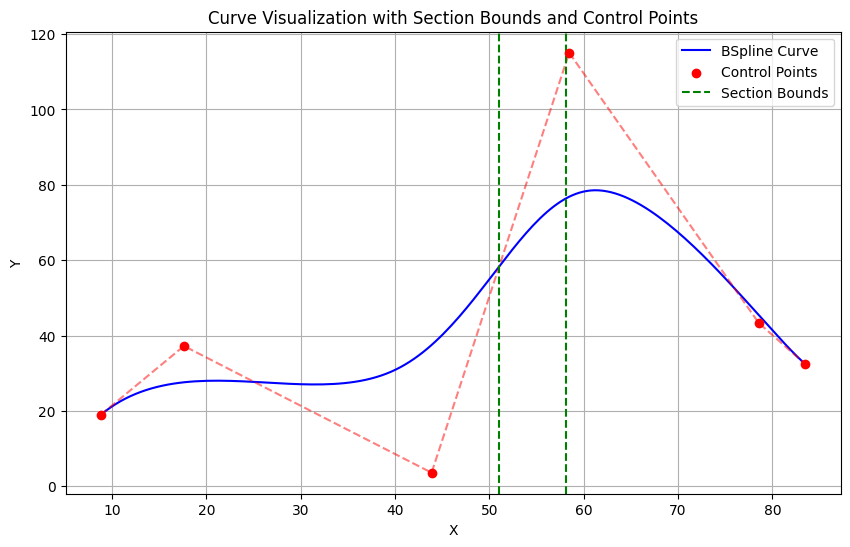

In [31]:
# Generate test data using vertical sections
num_curves = 100  # Total number of curves to generate
num_points = 6   # Number of control points per curve
plane_width = 100  # Width of the 2D plane
plane_height = 120  # Height of the 2D plane
num_samples = 161  # Number of points to sample per curve
noise_type = 'gaussian'
noise_level = 0.5

test_data_vertical_sections = create_test_data_vertical_sections(
    num_curves,
    num_points,
    plane_width,
    plane_height,
    num_samples=num_samples,
    noise_type=noise_type,
    noise_level=noise_level
)

# Visualize curve 6
curve6 = test_data_vertical_sections[6]
visualize_curve(curve6[0], curve6[1], curve6[2])

# Visualize curve 8
curve8 = test_data_vertical_sections[8]
visualize_curve(curve8[0], curve8[1], curve8[2])

